<!-- Copyright (c) 2021-2024, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# Knowledge Distillation Applied to AutoEncoder

In [1]:
import io
import math
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

from compressai.datasets import Vimeo90kDataset
from compressai.models.google import ScaleHyperprior

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

/home/ids/fallemand-24/anaconda3/envs/prim_env/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Load Models

In [3]:
N_teacher = 128
N_student = 64
M = 192

In [4]:
# Teacher Model
id = 254451
teacher_net = ScaleHyperprior(N_teacher, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
teacher_net.load_state_dict(checkpoint["state_dict"])
teacher_net = teacher_net.eval().to(device)

print(f"Parameters: {sum(p.numel() for p in teacher_net.parameters())}")

Parameters: 5075843


In [5]:
# Student Model
id = 254452
student_net = ScaleHyperprior(N_student, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint_best.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_net.load_state_dict(checkpoint["state_dict"])
student_net = student_net.eval().to(device)

print(f"Parameters: {sum(p.numel() for p in student_net.parameters())}")

Parameters: 1694339


In [13]:
# Student Model with KD
# id = 256893
id = 256894
student_kd_net = ScaleHyperprior(N_student, M)
checkpoint = torch.load(f"train_res/{id}/checkpoint.pth.tar",
    weights_only=True, map_location=torch.device("cpu"))
student_kd_net.load_state_dict(checkpoint["state_dict"])
student_kd_net = student_kd_net.eval().to(device)

print(f"Parameters: {sum(p.numel() for p in student_kd_net.parameters())}")

Parameters: 1694339


## Models Comparison

### Saint Malo

In [ ]:
test_transforms = transforms.Compose(
    [transforms.RandomCrop((256,256)), transforms.ToTensor()]
)

img = Image.open("../data/assets/stmalo_fracape.png").convert("RGB")
x = test_transforms(img).unsqueeze(0).to(device)
print(x.shape)

torch.Size([1, 3, 256, 256])


In [14]:
with torch.no_grad():
    teacher_out = teacher_net.forward(x)
    student_out = student_net.forward(x)
    student_kd_out = student_kd_net.forward(x)

criterion = nn.MSELoss()
teacher_loss = criterion(teacher_out["x_hat"], x)
student_loss = criterion(student_out["x_hat"], x)
student_kd_loss = criterion(student_kd_out["x_hat"], x)

teacher_diff = torch.mean((teacher_out["x_hat"] - x).abs(), axis=1).squeeze().cpu()
student_diff = torch.mean((student_out["x_hat"] - x).abs(), axis=1).squeeze().cpu()
student_kd_diff = torch.mean((student_kd_out["x_hat"] - x).abs(), axis=1).squeeze().cpu()

teacher_out = transforms.ToPILImage()(teacher_out["x_hat"].squeeze().cpu())
student_out = transforms.ToPILImage()(student_out["x_hat"].squeeze().cpu())
student_kd_out = transforms.ToPILImage()(student_kd_out["x_hat"].squeeze().cpu())

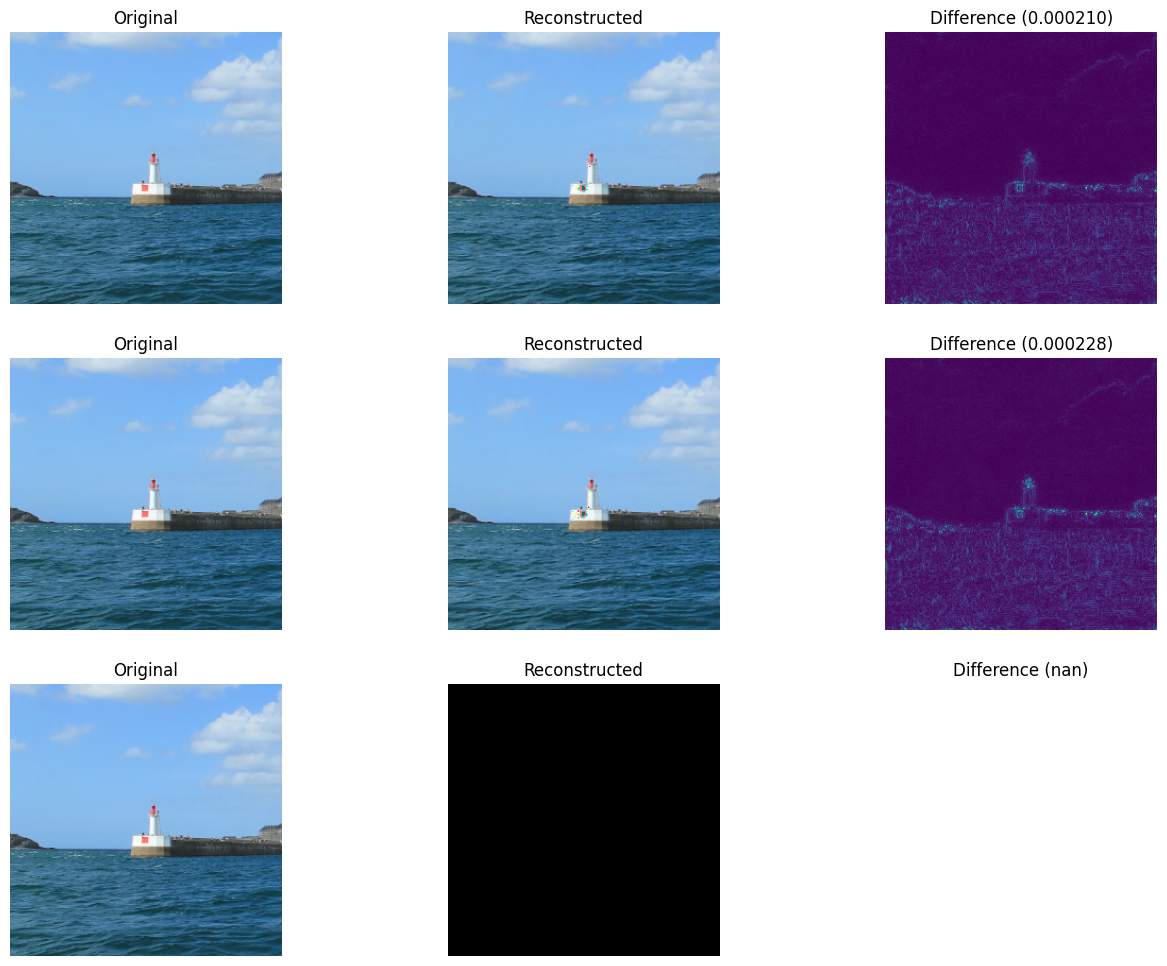

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

orig = transforms.ToPILImage()(x.squeeze().cpu())
outs = [teacher_out, student_out, student_kd_out]
diffs = [teacher_diff, student_diff, student_kd_diff]
losses = [teacher_loss, student_loss, student_kd_loss]

for ax in axs.ravel():
    ax.axis("off")

for i in range(3):
    axs[i, 0].imshow(orig)
    axs[i, 0].title.set_text("Original")

    axs[i, 1].imshow(outs[i])
    axs[i, 1].title.set_text("Reconstructed")

    axs[i, 2].imshow(diffs[i], cmap="viridis")
    axs[i, 2].title.set_text(f"Difference ({losses[i]:.6f})")

plt.show()

### Vimeo90k

In [ ]:
test_dataset = Vimeo90kDataset("/home/ids/fallemand-24/PRIM/data/vimeo/vimeo_triplet",
                               split="valid", transform=test_transforms)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=2,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

In [ ]:
img = test_dataset[0]

In [10]:
criterion = nn.MSELoss()

with torch.no_grad():
    for d in test_dataloader:
        # d = torch.reshape(d[0], ([-1, 3, 256, 256]))
        d = d.to(device)
        d_noisy = d + torch.randn_like(d) * 0.1
        
        _, teacher_out = teacher_net.forward(d_noisy)
        _, student_out = student_net.forward(d_noisy)
        _, student_kd_out = student_kd_net.forward(d_noisy)

        teacher_loss = criterion(teacher_out, d)
        student_loss = criterion(student_out, d)
        student_kd_loss = criterion(student_kd_out, d)

        teacher_diff = torch.mean((teacher_out - d).abs(), axis=1).squeeze().cpu()
        student_diff = torch.mean((student_out - d).abs(), axis=1).squeeze().cpu()
        student_kd_diff = torch.mean((student_kd_out - d).abs(), axis=1).squeeze().cpu()

        teacher_out = transforms.ToPILImage()(teacher_out[0].squeeze().cpu())
        student_out = transforms.ToPILImage()(student_out[0].squeeze().cpu())
        student_kd_out = transforms.ToPILImage()(student_kd_out[0].squeeze().cpu())

        break

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

orig = transforms.ToPILImage()(d[0].squeeze().cpu())
orig_noisy = transforms.ToPILImage()(d_noisy[0].squeeze().cpu())
outs = [teacher_out, student_out, student_kd_out]
diffs = [teacher_diff, student_diff, student_kd_diff]
losses = [teacher_loss, student_loss, student_kd_loss]

for ax in axs.ravel():
    ax.axis("off")

for i in range(3):
    axs[i, 0].imshow(orig)
    axs[i, 0].title.set_text("Original")

    axs[i, 1].imshow(orig_noisy)
    axs[i, 1].title.set_text("Input")

    axs[i, 2].imshow(outs[i])
    axs[i, 2].title.set_text("Reconstructed")

    axs[i, 3].imshow(diffs[i], cmap="viridis")
    axs[i, 3].title.set_text(f"Difference ({losses[i]:.3f})")

In [12]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=2,
    shuffle=False,
    pin_memory=(device == "cuda"),
)

In [ ]:
criterion = nn.MSELoss()

teacher_loss = AverageMeter()
student_loss = AverageMeter()
student_kd_loss = AverageMeter()

with torch.no_grad():
    for i, d in enumerate(test_dataloader):
        d = d.to(device)
        d_noisy = d + torch.randn_like(d) * 0.2
        
        _, teacher_out = teacher_net.forward(d_noisy)
        _, student_out = student_net.forward(d_noisy)
        _, student_kd_out = student_kd_net.forward(d_noisy)

        t_loss = criterion(teacher_out, d)
        s_loss = criterion(student_out, d)
        s_kd_loss = criterion(student_kd_out, d)

        teacher_loss.update(t_loss)
        student_loss.update(s_loss)
        student_kd_loss.update(s_kd_loss)

        if i == 10:
            break

print(f"Teacher loss: {teacher_loss.avg:.3f}")
print(f"Student oss: {student_loss.avg:.3f}")
print(f"Student KD loss: {student_kd_loss.avg:.3f}")